In [1]:
#!git clone https://github.com/invcble/Alzheimer-s-Classification-using-OASIS-Dataset

%cd /content/drive/MyDrive
from google.colab import drive
import os
import zipfile

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to the zip file and the extraction folder
zip_file_path = '/content/drive/My Drive/oasis_dataset.zip'  # Update this with your file's path
extract_to_path = '/content/OASIS Dataset'  # Extract to a folder in Colab's local storage

# Step 3: Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Zip file not found at {/content/drive/MyDrive/OASIS_Dataset}. Please upload it to the specified path.")
else:
    print(f"Zip file found at {/content/drive/MyDrive/OASIS_Dataset}. Extracting...")

    # Step 4: Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
    print(f"Dataset extracted to {extract_to_path}.")
    
    # Step 5: List the extracted files and folders
    print("Extracted files and folders:")
    for root, dirs, files in os.walk(extract_to_path):
        for name in dirs:
            print(f"Directory: {os.path.join(root, name)}")
        for name in files:
            print(f"File: {os.path.join(root, name)}")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

# Define paths to dataset
BASE_DIR = "OASIS_Dataset/"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Image dimensions and hyperparameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 4  # 4 categories of MRI images

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

# Build a model using ResNet50
def build_resnet_model():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation="softmax"),
    ])
    base_model.trainable = False  # Freeze the base model
    return model

# Build a model using VGG16
def build_vgg16_model():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation="softmax"),
    ])
    base_model.trainable = False  # Freeze the base model
    return model

# Compile and train the models
def compile_and_train(model, train_data, val_data, optimizer, loss, epochs, model_name):
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        steps_per_epoch=len(train_data),
        validation_steps=len(val_data),
    )
    model.save(f"{model_name}.h5")
    return history

# Train ResNet50 model
resnet_model = build_resnet_model()
print("Training ResNet50 model...")
compile_and_train(
    resnet_model,
    train_generator,
    val_generator,
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    epochs=EPOCHS,
    model_name="resnet50_alzheimers",
)

# Train VGG16 model
vgg16_model = build_vgg16_model()
print("Training VGG16 model...")
compile_and_train(
    vgg16_model,
    train_generator,
    val_generator,
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    epochs=EPOCHS,
    model_name="vgg16_alzheimers",
)

# Evaluate the models on the test set
print("Evaluating ResNet50 model...")
resnet_eval = resnet_model.evaluate(test_generator)
print(f"ResNet50 Test Accuracy: {resnet_eval[1] * 100:.2f}%")

print("Evaluating VGG16 model...")
vgg16_eval = vgg16_model.evaluate(test_generator)
print(f"VGG16 Test Accuracy: {vgg16_eval[1] * 100:.2f}%")


# Hyperparameters

In [2]:
random_state=37
max_epoch = 30
batch_size = 6400
image_size = 128
early_stopping_monitor = "val_loss"


# EACH LINK CONTAINS AVAILABLE OPTIONS
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes
optimizer = "adam"
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/metrics#classes
metrics = ["Accuracy", "Recall", "Precision"]
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions
loss_function = "categorical_crossentropy"
# Link: https://keras.io/api/applications/
model_name="ResNet50"

# dataset selection
SMALL_DATASET = 0
FULL_DATASET = 1
datasetdir =[r'./smalldataset', r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data'][SMALL_DATASET]

# add a comment about what changes you have done just now before running the training
what_changed = "additing option links, json format"



def save_hparams():
    
    hyprams = dict(
            timestamp = now.strftime("%H%M%S_%d%m%Y"),
            what_changed=what_changed,
            random_state=random_state,
            max_epoch=max_epoch,
            batch_size=batch_size,
            image_size=image_size,
            metrics=metrics,
            loss_function=loss_function,
            early_stopping_monitor=early_stopping_monitor,
            model_name=model_name,
            dataset=datasetdir,
            train=X_train.shape,
            validation=X_val.shape,
            test=X_test.shape,
        )
    import json 
    log("Saving hyperparameters.")
    # Convert and write JSON object to file
    with open(f"{artifact_root}/hyperparams.json", "w") as outfile: 
        json.dump(hyprams, outfile, indent=4)

# Prepare artifcat directory

In [3]:
import pathlib
import datetime
now = datetime.datetime.now()
artifact_root  = f"results/{model_name}/" + now.strftime("%H%M%S_%d%m%Y")
pathlib.Path(artifact_root).mkdir(parents=True, exist_ok=True)


stdout = open(f"{artifact_root}/additional_logs.txt", "w")
def log(*args, **kwargs):
    time = False
    if "time" in kwargs.keys():
        time = kwargs["time"]
        del kwargs["time"]
    if time:
        time = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
        a = list(args)
        a.append(time)
        args = tuple(a)
    print(*args, **kwargs)
    kwargs["file"] = stdout
    kwargs["flush"] = True
    print(*args, **kwargs)

In [4]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

In [5]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
log("Reading datafile names...1", end="")
for dirname, _, filenames in os.walk(datasetdir+r'/Non Demented'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            non_demented.append(os.path.join(dirname, filename))
log("...2", end="")
for dirname, _, filenames in os.walk(datasetdir+r'/Very mild Dementia'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            very_mild_demented.append(os.path.join(dirname, filename))
log("...3", end="")
for dirname, _, filenames in os.walk(datasetdir+r'/Mild Dementia'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            mild_demented.append(os.path.join(dirname, filename))
log("...4", end="")
for dirname, _, filenames in os.walk(datasetdir+r'/Moderate Dementia'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            moderate_demented.append(os.path.join(dirname, filename))
log("...DONE")

Reading datafile names...1...2...3...4...DONE


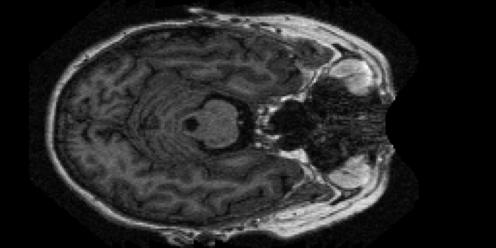

In [6]:
import PIL
from PIL import Image
PIL.Image.open(str(non_demented[0]))

In [7]:
log("file count non_demented=",len(non_demented))
log("file count mild_demented=",len(mild_demented))
log("file count moderate_demented=",len(moderate_demented))
log("file count very_mild_demented=", len(very_mild_demented))

file count non_demented= 6
file count mild_demented= 6
file count moderate_demented= 6
file count very_mild_demented= 7


In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [9]:
data = []
result = []
log("Reading images and encoding target ...1", end="")
for s in non_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
log("...2", end="")
for s in mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
log("...3", end="")
for s in moderate_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())
log("...4", end="")
for s in very_mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())
log("...DONE")

Reading images and encoding target ...1...2...3...4...DONE


In [10]:
X=np.array(data)

In [11]:
X.shape

(25, 128, 128, 3)

In [12]:
y=np.array(result)
y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

In [13]:
log("Splitting dataset into train, validation & testing...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Further splitting training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

Splitting dataset into train, validation & testing...


In [14]:
X_train.shape


(15, 128, 128, 3)

In [15]:
X_test.shape


(5, 128, 128, 3)

In [16]:
X_val.shape


(5, 128, 128, 3)

# Earlystopping

In [17]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Define the model architecture (ResNet50)
# import tensorflow.keras as K
log("Building model...")
import keras as K
input_t= K.Input(shape=(image_size,image_size,3))
res_model= getattr(K.applications, model_name)(include_top=False, weights="imagenet", input_tensor=input_t)
model_lenet = K.models.Sequential()
model_lenet.add(res_model)
model_lenet.add(K.layers.Flatten())
model_lenet.add(K.layers.Dense(4, activation='softmax'))

save_hparams()

Building model...


2024-11-28 00:30:08.371951: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-28 00:30:08.371970: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-28 00:30:08.371975: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-28 00:30:08.372074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-28 00:30:08.372318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Saving hyperparameters.


# Training

In [19]:
from keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger

# Ensure input data has correct shape
X_train = X_train.reshape(-1, image_size, image_size, 3)
X_test = X_test.reshape(-1, image_size, image_size, 3)
X_val = X_val.reshape(-1, image_size, image_size, 3)

# Ensure target labels are one-hot encoded
log("Encoding target to ONE_HOT format")
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

# Compile the model
log("Compile model")
metrics_o = [getattr(tf.keras.metrics, m)() for m in metrics]
model_lenet.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_o)

csv_logger = CSVLogger(artifact_root + '/metrics.csv')

# Train the model
log("Experiment: Started", time=True)
log(f"Starting training model={model_name}")
history = model_lenet.fit(X_train, y_train_encoded, epochs=max_epoch, batch_size=batch_size, 
                          callbacks = [csv_logger],
                          validation_data=(X_val, y_val_encoded))

Encoding target to ONE_HOT format
Compile model
Experiment: Started 00:30:09 28/11/2024
Starting training model=ResNet50
Epoch 1/30


2024-11-28 00:30:11.179209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1.7322 - accuracy: 0.0000e+00 - recall: 0.2667 - precision: 0.3333

2024-11-28 00:30:13.653685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 1.7322 - accuracy: 0.0000e+00 - recall: 0.2667 - precision: 0.3333 - val_loss: 2.7294 - val_accuracy: 0.0000e+00 - val_recall: 0.2000 - val_precision: 0.2000
Epoch 2/30
1/1 [==============================] - 0s 373ms/step - loss: 6.8424e-06 - accuracy: 0.1833 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9285 - val_accuracy: 0.0500 - val_recall: 0.4000 - val_precision: 0.4000
Epoch 3/30
1/1 [==============================] - 0s 193ms/step - loss: 2.1775e-06 - accuracy: 0.1833 - recall: 1.0000 - precision: 1.0000 - val_loss: 7.6831 - val_accuracy: 0.0500 - val_recall: 0.2000 - val_precision: 0.2000
Epoch 4/30
1/1 [==============================] - 0s 190ms/step - loss: 3.3378e-06 - accuracy: 0.2000 - recall: 1.0000 - precision: 1.0000 - val_loss: 13.9799 - val_accuracy: 0.0500 - val_recall: 0.2000 - val_precision: 0.2000
Epoch 5/30
1/1 [==============================] - 0s 184ms/step - loss: 5.8172e-06 - accuracy: 0.2000 - r

In [20]:
# Evaluate the model on the test set
log("Experiment: Evaluating", time=True)
log(f"Evaluating model={model_name}...")
x = model_lenet.evaluate(X_test, y_test_encoded)
metrics.append("test_loss")

Experiment: Evaluating 00:30:19 28/11/2024
Evaluating model=ResNet50...
1/1 [==============================] - 0s 32ms/step - loss: 55.2062 - accuracy: 0.0000e+00 - recall: 0.4000 - precision: 0.4000


In [21]:
log(f"{model_name}", {f"test_{k}":v for v,k in zip(x, metrics)})

ResNet50 {'test_Accuracy': 55.206207275390625, 'test_Recall': 0.0, 'test_Precision': 0.4000000059604645, 'test_test_loss': 0.4000000059604645}


In [22]:
log(f"Saving best model={model_name}")
model_lenet.save(artifact_root + f"/model_{model_name}.keras")

Saving best model=ResNet50


In [23]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
image_path = r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data/Non Demented/OAS1_0001_MR1_mpr-1_115.jpg'
if not os.path.exists(image_path):
    image_path = datasetdir+r'/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg'
image_array = preprocess_image(image_path)
log("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
log("Experiment: Testing", time=True)
prediction_probabilities = model_lenet.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labels
class_labels = ['non_demented', 'mild_demented', 'moderate_demented', 'very_mild_demented']

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

log("Predicted class:", predicted_class)
log("Experiment: Completed", time=True)

Shape of preprocessed image array: (1, 128, 128, 3)
Experiment: Testing 00:30:20 28/11/2024


2024-11-28 00:30:20.610920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 590ms/step
Predicted class: non_demented
Experiment: Completed 00:30:21 28/11/2024


In [24]:
# prompt: unzip in colab to specific folder

#!unzip ./OASIS dataset.zip -d ./OASIS/


In [25]:
# prompt: set path to my drive in colab

# import os
# path = "/drive/MyDrive" #You can change this path
# os.chdir(path)


In [26]:
# %cd /Drive/My Drive/

In [27]:
# %cd /content/drive/MyDrive/


In [28]:
# https://www.kaggle.com/datasets/ninadaithal/imagesoasis/code

In [29]:
stdout.close()